In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [88]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [203]:
df = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/data/train.csv')
df.head(10)

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,depvar
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769,0
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669,0
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674,0
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684,1
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664,1
5,0.1318,90000.0,3.48,7,0,0,2903,31,0,0,0,19548,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,7000,7000.0,0.0,1,7,236.47,0.854,0.0,0.0,1330.30,660,664,0
6,0.0791,60000.0,17.34,0,0,0,20399,35,0,0,0,117320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,20000,20000.0,0.0,1,18,625.90,0.369,0.0,0.0,2567.44,750,754,0
7,0.0975,79600.0,15.97,3,0,1,6481,17,0,0,0,18757,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,23800,23800.0,0.0,1,7,765.17,0.745,0.0,0.0,3006.76,680,684,0
8,0.0789,150000.0,7.36,1,0,0,15827,38,0,0,543,367504,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,16000,16000.0,0.0,1,19,500.58,0.334,0.0,0.0,1286.38,665,669,0
9,0.0999,95000.0,25.78,0,1,0,17870,37,0,0,0,273776,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,24,258.10,0.764,0.0,0.0,796.59,665,669,0


In [204]:
X = df.drop('depvar', axis=1)
y = df['depvar']

In [205]:
X

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high
0,0.0824,21000.0,29.19,0,1,0,3016,26,0,0,0,11773,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1200,1200.0,0.0,1,18,37.74,0.076,0.0,0.0,157.94,765,769
1,0.1299,80000.0,4.82,0,1,1,5722,24,0,0,0,21875,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8000,8000.0,0.0,1,8,269.52,0.447,0.0,0.0,1702.42,665,669
2,0.1299,38000.0,23.66,0,3,0,6511,18,0,0,0,31868,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,5000,5000.0,0.0,1,7,168.45,0.880,0.0,0.0,1066.64,670,674
3,0.1367,100000.0,16.27,4,2,0,6849,30,0,0,0,326049,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,15000,15000.0,0.0,1,12,510.27,0.457,0.0,0.0,1256.24,680,684
4,0.1269,30000.0,25.28,0,1,2,8197,12,0,0,2506,8840,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,10000,10000.0,0.0,1,8,335.45,0.416,0.0,0.0,871.04,660,664
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.1757,65000.0,17.67,0,3,1,11255,21,1,0,0,26570,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,20000,20000.0,0.0,1,13,718.75,0.780,0.0,0.0,5373.29,660,664
99996,0.0890,65000.0,2.88,0,0,0,2105,12,0,0,0,6138,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,6000,6000.0,0.0,1,7,190.52,0.120,0.0,0.0,835.66,765,769
99997,0.1349,46000.0,32.12,0,1,0,8998,20,0,0,0,96531,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,6400,6400.0,0.0,1,19,217.16,0.643,0.0,0.0,1261.67,665,669
99998,0.2115,31000.0,4.53,0,1,0,3875,4,0,0,0,3875,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,5500,5500.0,0.0,1,3,207.64,0.731,0.0,0.0,1357.69,710,714


In [206]:
y

0        0
1        0
2        0
3        1
4        1
        ..
99995    1
99996    0
99997    0
99998    1
99999    0
Name: depvar, Length: 100000, dtype: int64

In [207]:
# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state= 42)

In [208]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [209]:
X = X.values

In [210]:
cv.get_n_splits(X, y)

5

In [211]:
for train_index, valid_index in cv.split(X, y):
    print("train:", train_index, "valid:", valid_index)

    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]
    

train: [    1     3     4 ... 99996 99998 99999] valid: [    0     2     5 ... 99984 99994 99997]
train: [    0     2     3 ... 99996 99997 99998] valid: [    1     8     9 ... 99990 99995 99999]
train: [    0     1     2 ... 99996 99997 99999] valid: [    3     4    10 ... 99973 99993 99998]
train: [    0     1     2 ... 99997 99998 99999] valid: [   16    24    25 ... 99985 99988 99992]
train: [    0     1     2 ... 99997 99998 99999] valid: [    7    11    12 ... 99987 99991 99996]


In [213]:
for train_index, valid_index in cv.split(X, y):    
    scaler = MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_valid = scaler.transform(X_valid)

    print(X_train.shape)
    print(X_valid.shape)

(80000, 75)
(20000, 75)
(80000, 75)
(20000, 75)
(80000, 75)
(20000, 75)
(80000, 75)
(20000, 75)
(80000, 75)
(20000, 75)


In [165]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [249]:
drop_rate = 0.25

In [266]:
model = Sequential()
model.add(Dense(units=8, activation='relu'))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(Dense(units=4, activation='relu'))
model.add(tf.keras.layers.Dropout(drop_rate))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[f1])

In [267]:
model.fit(x=X_train, 
              y=y_train,
              epochs=500,
              batch_size=256,
              validation_data=(X_valid, y_valid), verbose=1)

Epoch 1/500
313/313 [==============================] - 2s 3ms/step - loss: 0.6291 - f1: 0.0465 - val_loss: 0.6008 - val_f1: 0.0000e+00
Epoch 2/500
313/313 [==============================] - 1s 3ms/step - loss: 0.6079 - f1: 5.1839e-04 - val_loss: 0.5893 - val_f1: 0.0000e+00
Epoch 3/500
313/313 [==============================] - 1s 3ms/step - loss: 0.5994 - f1: 0.0034 - val_loss: 0.5817 - val_f1: 0.0000e+00
Epoch 4/500
313/313 [==============================] - 1s 3ms/step - loss: 0.5930 - f1: 0.0959 - val_loss: 0.5738 - val_f1: 0.0306
Epoch 5/500
313/313 [==============================] - 1s 3ms/step - loss: 0.5864 - f1: 0.2388 - val_loss: 0.5661 - val_f1: 0.2736
Epoch 6/500
313/313 [==============================] - 1s 3ms/step - loss: 0.5822 - f1: 0.2938 - val_loss: 0.5610 - val_f1: 0.3498
Epoch 7/500
313/313 [==============================] - 1s 3ms/step - loss: 0.5771 - f1: 0.3255 - val_loss: 0.5551 - val_f1: 0.4191
Epoch 8/500
313/313 [==============================] - 1s 3ms/step 

In [268]:
losses = pd.DataFrame(model.history.history)

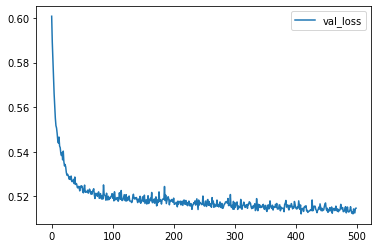

In [269]:
losses[['val_loss']].plot()

In [270]:
# 평가 함수 정의
def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')

In [271]:
y_pred_ANN = model.predict(X_valid)

In [272]:
y_pred_ANN

array([[0.39075872],
       [0.27399236],
       [0.5694758 ],
       ...,
       [0.28520313],
       [0.21067017],
       [0.0531651 ]], dtype=float32)


정확도: 0.7167
정밀도: 0.5483
재현율: 0.7404
AUC: 0.7229
F1: 0.7003


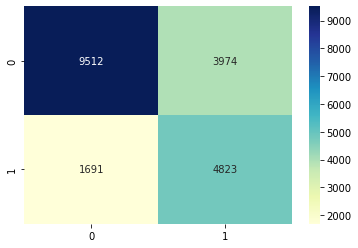

In [273]:
get_clf_eval(y_valid,  y_pred_ANN > 0.34
             )


In [26]:
df_test = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/test.csv')

In [27]:
df_test.head()

,int_rate,annual_inc,dti,delinq_2yrs,inq_last_6mths,pub_rec,revol_bal,total_acc,collections_12_mths_ex_med,acc_now_delinq,tot_coll_amt,tot_cur_bal,chargeoff_within_12_mths,delinq_amnt,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose1,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,initial_list_status1,initial_list_status2,mths_since_last_delinq1,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,funded_amnt,funded_amnt_inv,total_rec_late_fee,term1,open_acc,installment,revol_util,out_prncp,out_prncp_inv,total_rec_int,fico_range_low,fico_range_high,ID
0,0.1449,16380.0,26.08,0,0,1,3486,10,0,0,0,9214,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,8100,8100.0,0.00,1,4,278.78,0.311,0.0,0.0,460.40,700,704,0
1,0.1899,65000.0,13.97,0,0,0,25305,20,0,0,0,115612,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,20000,20000.0,0.00,0,10,518.71,0.885,0.0,0.0,4866.68,675,679,1
2,0.1049,53000.0,23.28,0,0,0,10910,21,0,0,0,33017,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,10000,10000.0,16.25,1,7,324.98,0.580,0.0,0.0,1451.06,675,679,2
3,0.1757,71800.0,30.32,0,0,0,42423,26,0,0,0,152515,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,27200,27200.0,0.00,0,16,684.36,0.701,0.0,0.0,7068.11,665,669,3
4,0.2020,50000.0,25.61,0,2,0,21703,24,0,0,0,135282,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,22000,22000.0,0.00,0,13,585.32,0.622,0.0,0.0,7754.20,710,714,4


In [29]:
X_test = df_test.drop(['ID'], axis=1)

In [30]:
X_test = scaler.transform(X_test)

In [51]:
predictions = (model.predict(X_test) > 0.4).astype("int32")

In [52]:
predictions.sum(), len(X_test)

(14971, 35816)

In [53]:
predictions

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [54]:
submit = pd.read_csv('/content/drive/MyDrive/28. 20220126_DAY27(1주차 모의경진대회)/sample_submission.csv')


submit.head(20)

,ID,answer
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
5,5,0
6,6,0
7,7,0
8,8,0
9,9,0


In [55]:
submit['answer'] = predictions

In [57]:
submit.to_csv('/content/drive/MyDrive/prediction51.csv', index=False)